In [1]:
import os
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Lambda, Input
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19
import numpy as np

from imblearn.over_sampling import RandomOverSampler


In [2]:
img_size = 48
seed = 88
batch_size = 128
epochs = 100

# input path for the images
base_path = "facial_emotion_dataset/"
train_dir = base_path + "train"
val_dir = base_path + "validation"

# Verifica se o diretório já existe
if not os.path.exists("saved_models"):
    # Se não existir, cria o diretório
    os.makedirs("saved_models")
    print(f"A pasta '{"saved_models"}' foi criada com sucesso.")
else:
    print(f"A pasta '{"saved_models"}' já existe.")

model_folder = "saved_models/"

A pasta 'saved_models' já existe.


In [3]:
# Função para listar os arquivos e suas etiquetas
def listar_arquivos_e_etiquetas(diretorio_base):
    data = []
    for pasta in os.listdir(diretorio_base):
        pasta_path = os.path.join(diretorio_base, pasta)
        if os.path.isdir(pasta_path):
            for arquivo in os.listdir(pasta_path):
                arquivo_path = os.path.join(pasta_path, arquivo)
                data.append((arquivo_path, pasta))
    return data

# Lista de todos os arquivos e etiquetas nos diretórios
train_files = listar_arquivos_e_etiquetas(train_dir)
val_files = listar_arquivos_e_etiquetas(val_dir)

# Criar DataFrame
df_train = pd.DataFrame(train_files, columns=['Caminho', 'Etiqueta'])
df_val = pd.DataFrame(val_files, columns=['Caminho', 'Etiqueta'])

df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=seed)

C:\Users\pedro\AppData\Local\Temp\ipykernel_23516\1361161807.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_por_classe.index, y=contagem_por_classe.values, palette='viridis')


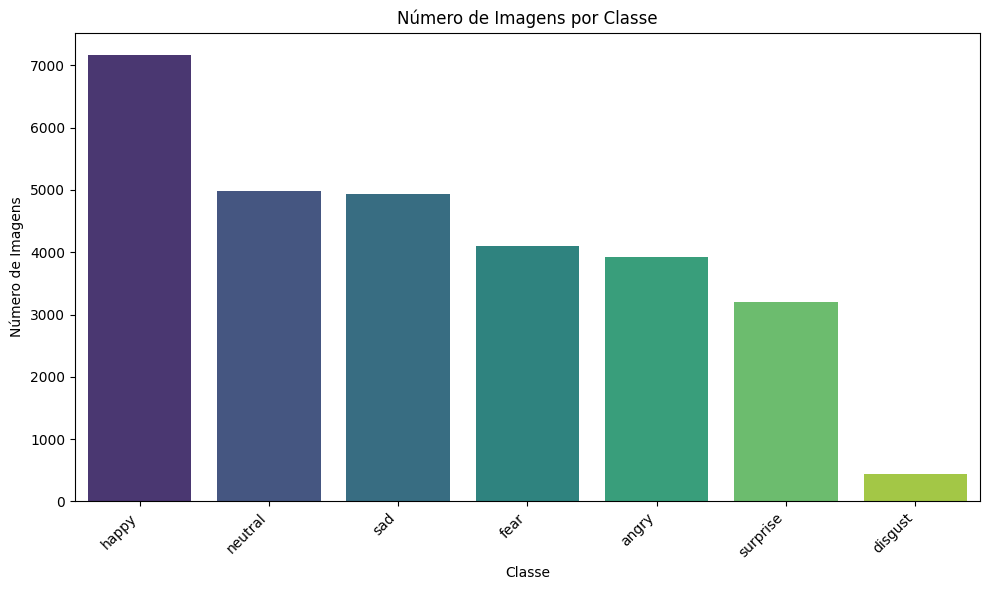

In [4]:
# Contagem de imagens por classe
contagem_por_classe = df_train['Etiqueta'].value_counts()

# Crie o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=contagem_por_classe.index, y=contagem_por_classe.values, palette='viridis')
plt.title('Número de Imagens por Classe')
plt.xlabel('Classe')
plt.ylabel('Número de Imagens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Data Augmentation

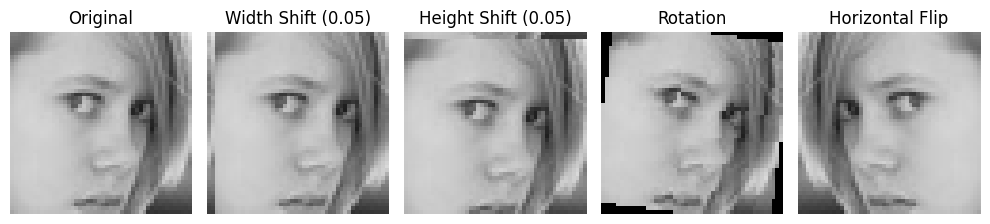

In [5]:
from PIL import Image

# Definir os parâmetros das transformações
width_shift_range = 0.05
height_shift_range = 0.05
rotation_range = 10

# Carregar a imagem original
ex_img_dir = df_train['Caminho'][42]
img = load_img(ex_img_dir)

# Converter a imagem para array
img_array = img_to_array(img)

# Aplicar deslocamento horizontal
img_shifted_width = np.roll(img_array, int(width_shift_range * img_array.shape[1]), axis=1)

# Aplicar deslocamento vertical
img_shifted_height = np.roll(img_array, int(height_shift_range * img_array.shape[0]), axis=0)

# Aplicar rotação
rotation_angle = np.random.uniform(-rotation_range, rotation_range)
img_rotated = np.array(Image.fromarray(img_array.astype('uint8')).rotate(rotation_angle))

# Aplicar flip horizontal
img_flipped = np.fliplr(img_array)

# Configurar o plot
plt.figure(figsize=(10, 5))

# Plotar imagem original
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

# Plotar imagem com deslocamento horizontal
plt.subplot(1, 5, 2)
plt.imshow(img_shifted_width.astype('uint8'))
plt.axis('off')
plt.title(f'Width Shift ({width_shift_range})')

# Plotar imagem com deslocamento vertical
plt.subplot(1, 5, 3)
plt.imshow(img_shifted_height.astype('uint8'))
plt.axis('off')
plt.title(f'Height Shift ({height_shift_range})')

# Plotar imagem com rotação
plt.subplot(1, 5, 4)
plt.imshow(img_rotated.astype('uint8'))
plt.axis('off')
plt.title(f'Rotation')

# Plotar imagem com flip horizontal
plt.subplot(1, 5, 5)
plt.imshow(img_flipped.astype('uint8'))
plt.axis('off')
plt.title('Horizontal Flip')

plt.tight_layout()
plt.show()

Carregamento das Imagens

In [6]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   width_shift_range = 0.05,
                                   height_shift_range = 0.05,
                                   rotation_range = 10,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale= 1.0/255)

In [7]:
def create_generators(df_train, df_val, df_test, data_augmentation):
    if data_augmentation:
        train_generator = train_datagen.flow_from_dataframe(
            df_train,
            x_col="Caminho",
            y_col="Etiqueta",
            target_size=(img_size, img_size),
            color_mode="grayscale",
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
        )
    else:
        train_generator = val_datagen.flow_from_dataframe(
            df_train,
            x_col="Caminho",
            y_col="Etiqueta",
            target_size=(img_size, img_size),
            color_mode="grayscale",
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
        )

    val_generator = val_datagen.flow_from_dataframe(
        df_val,
        x_col="Caminho",
        y_col="Etiqueta",
        target_size=(img_size, img_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    test_generator = val_datagen.flow_from_dataframe(
        df_test,
        x_col="Caminho",
        y_col="Etiqueta",
        target_size=(img_size, img_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    return train_generator, val_generator, test_generator

# Cenários

<img src="ProjectDiagram.jpg" alt="Descrição da Imagem" style="width:800px;" />

Cenário 1 - Sem pré-processamento

In [8]:
train_generator_cen1, val_generator_cen1, test_generator_cen1 = create_generators(df_train, df_val, df_test, data_augmentation=False)

Found 28741 validated image filenames belonging to 7 classes.
Found 3533 validated image filenames belonging to 7 classes.
Found 3533 validated image filenames belonging to 7 classes.


In [9]:
def define_model_4_layers(image_size, train_generator):
    # Obtém o número de classes
    num_classes = len(train_generator.class_indices)

    # Initialising the CNN
    model = Sequential()

    # 1 - Convolution
    model.add(Conv2D(64,(3,3), padding='same', input_shape=(image_size, image_size,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Convolution layer
    model.add(Conv2D(128,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 3rd Convolution layer
    model.add(Conv2D(256,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 4th Convolution layer
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    # Fully connected layer 2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))

    print(model.summary())

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model



In [10]:
def define_model_3_layers(image_size, train_generator):
    # Obtém o número de classes
    num_classes = len(train_generator.class_indices)

    # Initialising the CNN
    model = Sequential()

    # 1 - Convolution
    model.add(Conv2D(64,(3,3), padding='same', input_shape=(image_size, image_size,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Convolution layer
    model.add(Conv2D(128,(5,5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 3rd Convolution layer
    model.add(Conv2D(256,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening
    model.add(Flatten())

    # Fully connected layer layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))

    print(model.summary())

    model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return model



In [11]:
#model_cen1 = define_model_3_layers(img_size, train_generator_cen1)
model_cen1 = define_model_4_layers(img_size, train_generator_cen1)

c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 2,871,815 (10.96 MB)

 Trainable params: 2,868,359 (10.94 MB)

 Non-trainable params: 3,456 (13.50 KB)

None


In [12]:
def train_and_evaluate_model(model, train_generator, val_generator, test_generator, epochs, model_save_path, early_stopping_patience=10):

    # Definição de callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)
    checkpoint = ModelCheckpoint('model_weights_best.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [early_stopping, checkpoint, reduce_learningrate]
    
    # Treinamento do modelo
    history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks_list)
    
    # Avaliação do modelo no conjunto de teste
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy}")
    
    # Salvar o modelo treinado
    model.save(model_folder + model_save_path)
    
    # Representação gráfica do comportamento da accuracy e loss function
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='green', linestyle='--', label='Test Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], color='red', label='Training Loss')
    plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
    plt.axhline(y=test_loss, color='green', linestyle='--', label='Test Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Compute predictions on the test set
    #y_true = test_generator.classes
    #y_pred = model.predict(test_generator)
    #y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Compute the confusion matrix
    #cm = confusion_matrix(y_true, y_pred_classes)
    
    # Display the confusion matrix
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    #disp.plot(cmap='Blues', values_format='d')
    #plt.title('Confusion Matrix')
    #plt.show()

    #print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))



Epoch 1/100


c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2655 - loss: 1.9231
Epoch 1: val_loss improved from inf to 2.01834, saving model to model_weights_best.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.2657 - loss: 1.9225 - val_accuracy: 0.1678 - val_loss: 2.0183 - learning_rate: 0.0010
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4255 - loss: 1.4987
Epoch 2: val_loss improved from 2.01834 to 1.70180, saving model to model_weights_best.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.4256 - loss: 1.4985 - val_accuracy: 0.2836 - val_loss: 1.7018 - learning_rate: 0.0010
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4958 - loss: 1.3083
Epoch 3: val_loss improved from 1.70180 to 1.24984, saving model to model_weights_best.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.4959 - loss: 1.3082 - val_accuracy: 0.5205 - val_loss: 1.2498 - learning_rate: 0.0010
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step -

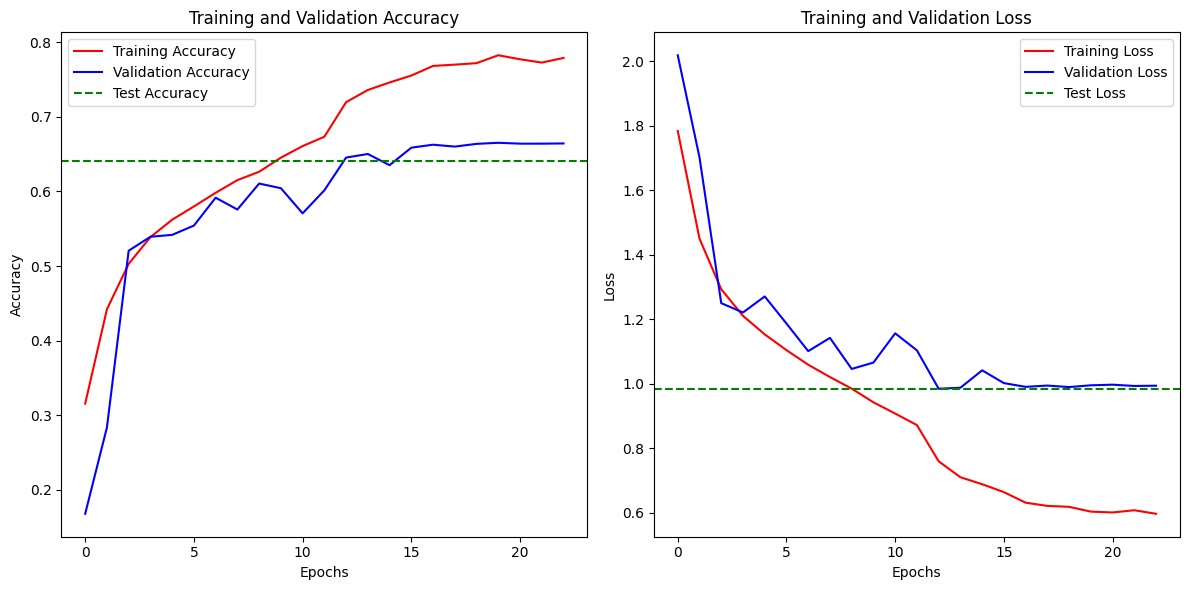

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 373ms/step


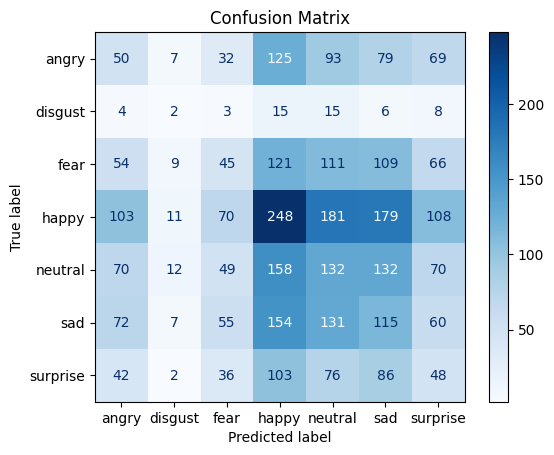

              precision    recall  f1-score   support

       angry       0.13      0.11      0.12       455
     disgust       0.04      0.04      0.04        53
        fear       0.16      0.09      0.11       515
       happy       0.27      0.28      0.27       900
     neutral       0.18      0.21      0.19       623
         sad       0.16      0.19      0.18       594
    surprise       0.11      0.12      0.12       393

    accuracy                           0.18      3533
   macro avg       0.15      0.15      0.15      3533
weighted avg       0.18      0.18      0.18      3533



In [13]:
train_and_evaluate_model(model_cen1, train_generator_cen1, val_generator_cen1, test_generator_cen1, epochs=epochs, model_save_path='CNN_Cenario1.keras')

Cenário 2 - Undersampling

In [14]:
def balanced_sample(df, random_state=None):
    # Determine the desired number of images per class
    num_images_per_class = min(df['Etiqueta'].value_counts())
    
    # List to store sampled DataFrames of each class
    samples = []
    
    # Loop through each class in the DataFrame
    for class_label in df['Etiqueta'].unique():
        class_sample = df[df['Etiqueta'] == class_label].sample(n=num_images_per_class, random_state=random_state)
        samples.append(class_sample)
    
    # Concatenate the samples to create the new balanced dataset
    balanced_df = pd.concat(samples)
    
    return balanced_df

df_train_cen2 = balanced_sample(df_train, random_state=seed)
df_val_cen2 = balanced_sample(df_val, random_state=seed)
df_test_cen2 = balanced_sample(df_test, random_state=seed)

In [15]:
train_generator_cen2, val_generator_cen2, test_generator_cen2 = create_generators(df_train_cen2, df_val_cen2, df_test_cen2, data_augmentation=True)

Found 3052 validated image filenames belonging to 7 classes.
Found 406 validated image filenames belonging to 7 classes.
Found 371 validated image filenames belonging to 7 classes.


In [16]:
#model_cen2 = define_model_3_layers(img_size, train_generator_cen2)
model_cen2 = define_model_4_layers(img_size, train_generator_cen2)

c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,02

 Total params: 2,871,815 (10.96 MB)

 Trainable params: 2,868,359 (10.94 MB)

 Non-trainable params: 3,456 (13.50 KB)

None


Epoch 1/100


c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1649 - loss: 2.3195
Epoch 1: val_loss improved from inf to 1.98210, saving model to model_weights_best.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1652 - loss: 2.3165 - val_accuracy: 0.1429 - val_loss: 1.9821 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1815 - loss: 2.1151
Epoch 2: val_loss did not improve from 1.98210
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.1817 - loss: 2.1143 - val_accuracy: 0.1429 - val_loss: 2.0019 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2216 - loss: 2.0183
Epoch 3: val_loss did not improve from 1.98210
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2217 - loss: 2.0186 - val_accuracy: 0.1429 - val_loss: 2.0298 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2570 - loss: 1.9229
Epoch 4: val_loss did not improve from 1.98210

Epoch 4: ReduceLROnPlateau r

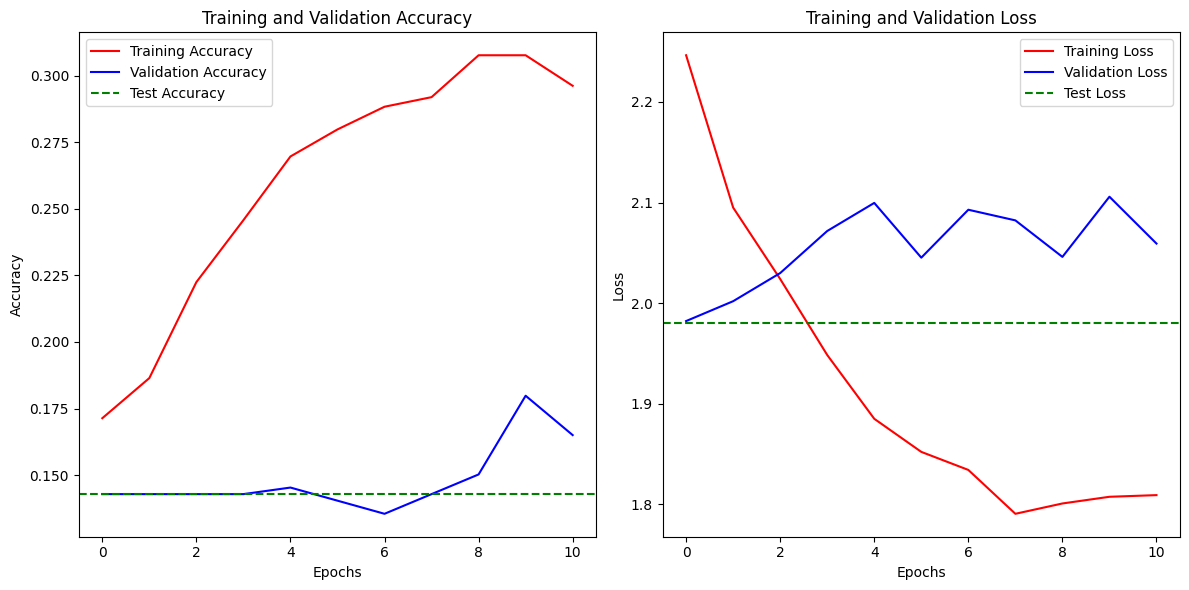

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step


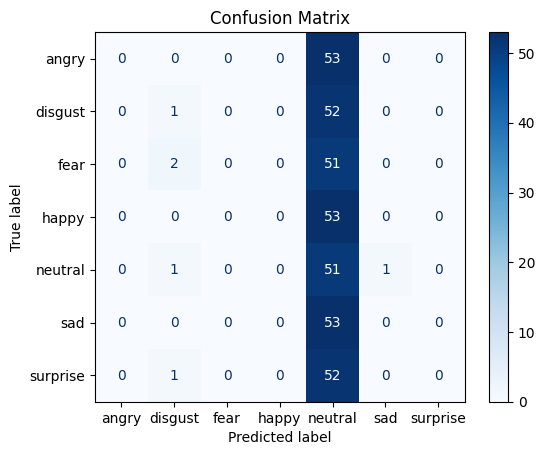

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        53
     disgust       0.20      0.02      0.03        53
        fear       0.00      0.00      0.00        53
       happy       0.00      0.00      0.00        53
     neutral       0.14      0.96      0.24        53
         sad       0.00      0.00      0.00        53
    surprise       0.00      0.00      0.00        53

    accuracy                           0.14       371
   macro avg       0.05      0.14      0.04       371
weighted avg       0.05      0.14      0.04       371



c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [17]:
train_and_evaluate_model(model_cen2, train_generator_cen2, val_generator_cen2, test_generator_cen2, epochs=epochs, model_save_path='CNN_Cenario2.keras')

Cenário 3 - Undersampling, não considerando a classe "disgust"

In [18]:
df_train_cen3 = df_train[df_train['Etiqueta'] != 'disgust']
df_val_cen3 = df_val[df_val['Etiqueta'] != 'disgust']
df_test_cen3 = df_test[df_test['Etiqueta'] != 'disgust']

In [19]:
df_train_cen3 = balanced_sample(df_train_cen3, random_state=seed)
df_val_cen3 = balanced_sample(df_val_cen3, random_state=seed)
df_test_cen3 = balanced_sample(df_test_cen3, random_state=seed)

C:\Users\pedro\AppData\Local\Temp\ipykernel_23516\1108405757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_por_classe_amostrado.index, y=contagem_por_classe_amostrado.values, palette='viridis')


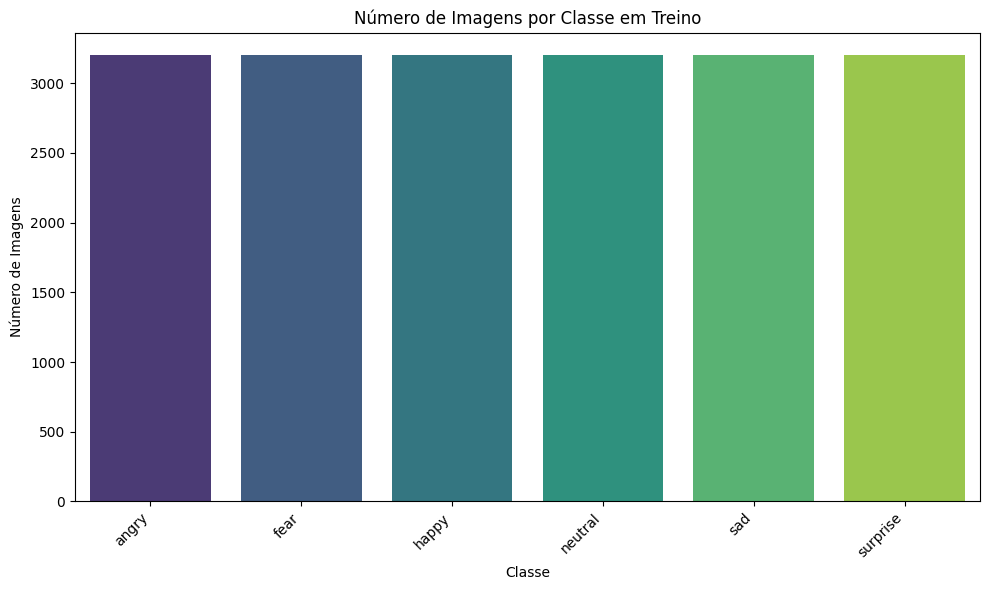

In [20]:
# Contagem de imagens por classe
contagem_por_classe_amostrado = df_train_cen3['Etiqueta'].value_counts()

# Crie o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=contagem_por_classe_amostrado.index, y=contagem_por_classe_amostrado.values, palette='viridis')
plt.title('Número de Imagens por Classe em Treino')
plt.xlabel('Classe')
plt.ylabel('Número de Imagens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
train_generator_cen3, val_generator_cen3, test_generator_cen3 = create_generators(df_train_cen3, df_val_cen3, df_test_cen3, data_augmentation=True)

Found 19212 validated image filenames belonging to 6 classes.
Found 2424 validated image filenames belonging to 6 classes.
Found 2358 validated image filenames belonging to 6 classes.


In [22]:
model_cen3 = define_model_4_layers(img_size, train_generator_cen3)
#model_cen3 = define_model_3_layers(img_size, train_generator_cen3)

c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,02

 Total params: 2,871,302 (10.95 MB)

 Trainable params: 2,867,846 (10.94 MB)

 Non-trainable params: 3,456 (13.50 KB)

None


Epoch 1/100


c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2167 - loss: 1.9785
Epoch 1: val_loss improved from inf to 1.92011, saving model to model_weights_best.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.2168 - loss: 1.9778 - val_accuracy: 0.1667 - val_loss: 1.9201 - learning_rate: 0.0010
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3086 - loss: 1.6942
Epoch 2: val_loss improved from 1.92011 to 1.83552, saving model to model_weights_best.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.3088 - loss: 1.6939 - val_accuracy: 0.1753 - val_loss: 1.8355 - learning_rate: 0.0010
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3908 - loss: 1.5214
Epoch 3: val_loss did not improve from 1.83552
151/151 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.3908 - loss: 1.5213 - val_accuracy: 0.2715 - val_loss: 1.8551 - learning_rate: 0.0010
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4428 - loss: 1.3988
Epoch 4: val_

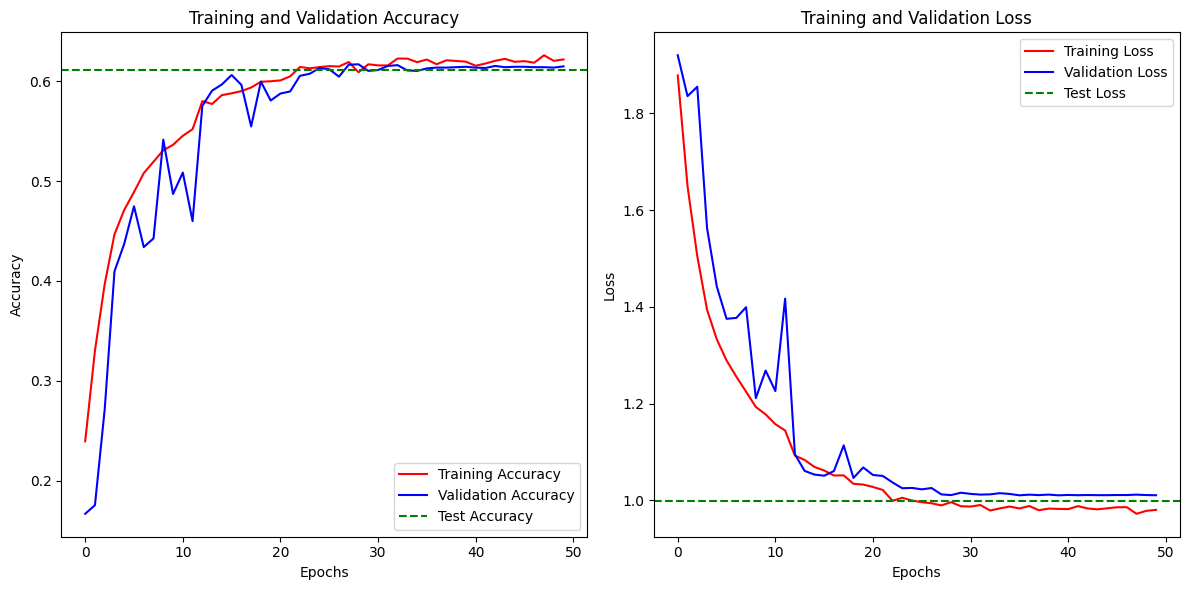

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step


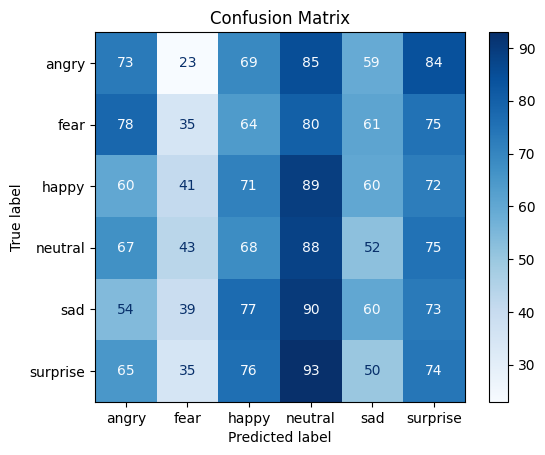

              precision    recall  f1-score   support

       angry       0.18      0.19      0.18       393
        fear       0.16      0.09      0.11       393
       happy       0.17      0.18      0.17       393
     neutral       0.17      0.22      0.19       393
         sad       0.18      0.15      0.16       393
    surprise       0.16      0.19      0.17       393

    accuracy                           0.17      2358
   macro avg       0.17      0.17      0.17      2358
weighted avg       0.17      0.17      0.17      2358



In [23]:
train_and_evaluate_model(model_cen3, train_generator_cen3, val_generator_cen3, test_generator_cen3, epochs=epochs, model_save_path='CNN_Cenario3.keras')

Cenário 4 - Oversampling

In [24]:
def oversample_dataframe(df, x_col, y_col):

    # Contamos o número de amostras em cada classe
    class_counts = df[y_col].value_counts()
    
    # Encontramos a classe com o maior número de amostras
    max_count = class_counts.max()
    
    # Inicializamos o RandomOverSampler
    ros = RandomOverSampler(sampling_strategy={cls: max_count for cls in class_counts.index})
    
    # Realizamos o oversampling
    df_resampled, _ = ros.fit_resample(df, df[y_col])
    
    # Convertendo de volta para um DataFrame, pois ros.fit_resample retorna arrays
    df_resampled = pd.DataFrame(df_resampled, columns=df.columns)
    
    return df_resampled

# Exemplo de uso
df_train_cen4 = oversample_dataframe(df_train, x_col='Caminho', y_col='Etiqueta')
df_val_cen4 = oversample_dataframe(df_val, x_col='Caminho', y_col='Etiqueta')
df_test_cen4 = oversample_dataframe(df_test, x_col='Caminho', y_col='Etiqueta')


In [25]:
train_generator_cen4, val_generator_cen4, test_generator_cen4 = create_generators(df_train_cen4, df_val_cen4, df_test_cen4, data_augmentation=True)

Found 50148 validated image filenames belonging to 7 classes.
Found 6475 validated image filenames belonging to 7 classes.
Found 6300 validated image filenames belonging to 7 classes.


In [26]:
model_cen4 = define_model_4_layers(img_size, train_generator_cen4)
#model_cen4 = define_model_3_layers(img_size, train_generator_cen4)

c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,02

 Total params: 2,871,815 (10.96 MB)

 Trainable params: 2,868,359 (10.94 MB)

 Non-trainable params: 3,456 (13.50 KB)

None


Epoch 1/100


c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2308 - loss: 2.0081
Epoch 1: val_loss improved from inf to 1.93695, saving model to model_weights_best.keras
392/392 ━━━━━━━━━━━━━━━━━━━━ 583s 1s/step - accuracy: 0.2310 - loss: 2.0076 - val_accuracy: 0.2885 - val_loss: 1.9370 - learning_rate: 0.0010
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4222 - loss: 1.5070
Epoch 2: val_loss improved from 1.93695 to 1.50381, saving model to model_weights_best.keras
392/392 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.4222 - loss: 1.5069 - val_accuracy: 0.4497 - val_loss: 1.5038 - learning_rate: 0.0010
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5055 - loss: 1.3074
Epoch 3: val_loss improved from 1.50381 to 1.27498, saving model to model_weights_best.keras
392/392 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.5055 - loss: 1.3073 - val_accuracy: 0.5237 - val_loss: 1.2750 - learning_rate: 0.0010
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step -

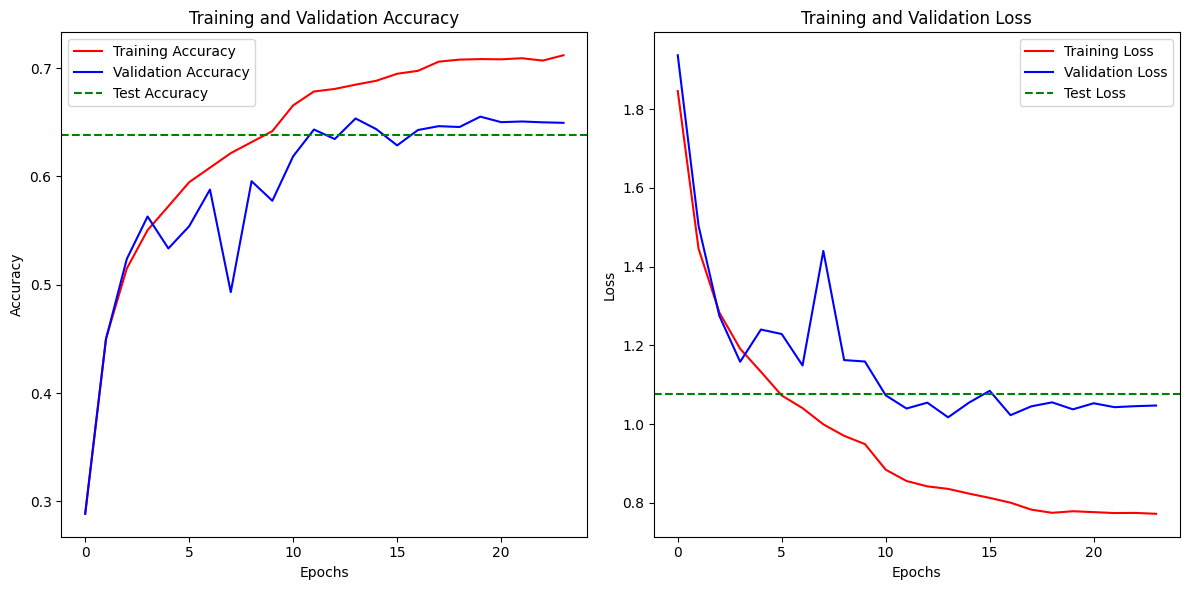

50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step


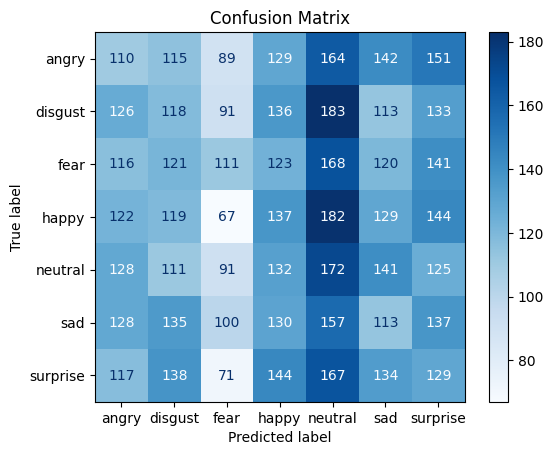

              precision    recall  f1-score   support

       angry       0.13      0.12      0.13       900
     disgust       0.14      0.13      0.13       900
        fear       0.18      0.12      0.15       900
       happy       0.15      0.15      0.15       900
     neutral       0.14      0.19      0.16       900
         sad       0.13      0.13      0.13       900
    surprise       0.13      0.14      0.14       900

    accuracy                           0.14      6300
   macro avg       0.14      0.14      0.14      6300
weighted avg       0.14      0.14      0.14      6300



In [27]:
train_and_evaluate_model(model_cen4, train_generator_cen4, val_generator_cen4, test_generator_cen4, epochs=epochs, model_save_path='CNN_Cenario4.keras')

# Transfer Learning - VGG19 - Sem preprocessamento

In [ ]:
# Função para converter grayscale para 3 canais + preprocessamento
def grayscale_to_rgb(x):
    x = tf.image.grayscale_to_rgb(x)
    return x

# Carregar o modelo VGG19 pré-treinado
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Converter a entrada para grayscale e depois para 3 canais
input_tensor = Input(shape=(img_size, img_size, 1))
x = Lambda(grayscale_to_rgb)(input_tensor)

# Conectar ao modelo base
x = base_model(x)

# Adicionar camadas densas personalizadas
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(7, activation='softmax')(x)

# Criar o modelo final
model_vgg19 = Model(inputs=input_tensor, outputs=output_tensor)

# Congelar as camadas convolucionais do VGG19
for layer in base_model.layers:
    layer.trainable = False

# Compilar o modelo
model_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model_vgg19.summary()

train_and_evaluate_model(model_vgg19, train_generator_cen3, val_generator_cen3, test_generator_cen3, epochs=epochs, model_save_path='VGG_SemPreprocessamento.keras')


# Transfer Learning - VGG19 - Com preprocessamento

In [ ]:
from keras.applications.vgg19 import preprocess_input

# Define the preprocess_vgg19 function
def preprocess_vgg19(x):
    x = tf.image.grayscale_to_rgb(x)
    x = preprocess_input(x)
    return x

# Carregar o modelo VGG19 pré-treinado
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Converter a entrada para grayscale e depois para 3 canais
input_tensor = Input(shape=(img_size, img_size, 3))
x = Lambda(preprocess_vgg19, output_shape=(img_size, img_size, 3))(input_tensor)

# Conectar ao modelo base
x = base_model(x)

# Adicionar camadas densas personalizadas
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(7, activation='softmax')(x)

# Criar o modelo final
model_vgg19_2 = Model(inputs=input_tensor, outputs=output_tensor)

# Congelar as camadas convolucionais do VGG19
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compilar o modelo
model_vgg19_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model_vgg19_2.summary()

train_and_evaluate_model(model_vgg19_2, train_generator_cen1, val_generator_cen1, test_generator_cen1, epochs=epochs, model_save_path='VGG_ComPreprocessamento.keras')

# FER em Tempo Real

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Carregue o modelo treinado
best_model = load_model('saved_models\CNN_Cenario3.keras')

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Carregue o modelo treinado
best_model = load_model('saved_models\CNNComHiperparametros.keras')
# Load the Haar cascade classifier for face detection
haar_file = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_file)

# Define a function to extract features from an image
def extract_features(image):
    feature = np.array(image)
    feature = feature.reshape(1, 48, 48, 1)
    return feature / 255.0

# Open the webcam (camera)
webcam = cv2.VideoCapture(0)

# Define labels for emotion classes
labels = {0: 'angry', 1: 'fear', 2: 'happy', 3: 'neutral', 4: 'sad', 5: 'surprise'}

while True:
    # Read a frame from the webcam
    i, im = webcam.read()

    # Convert the frame to grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale frame
    faces = face_cascade.detectMultiScale(im, 1.3, 5)

    try:
        # For each detected face, perform facial emotion recognition
        for (p, q, r, s) in faces:
            # Extract the region of interest (ROI) which contains the face
            image = gray[q:q + s, p:p + r]

            # Draw a rectangle around the detected face
            cv2.rectangle(im, (p, q), (p + r, q + s), (255, 0, 0), 2)

            # Resize the face image to the required input size (48x48)
            image = cv2.resize(image, (48, 48))

            # Extract features from the resized face image
            img = extract_features(image)

            # Make a prediction using the trained model
            pred = best_model.predict(img)

            # Get the predicted label for emotion
            prediction_label = labels[pred.argmax()]

            # Display the predicted emotion label near the detected face
            cv2.putText(im, f'Emotion: {prediction_label}', (p - 10, q - 10),
                        cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (0, 0, 255))

        # Display the frame with annotations in real-time
        cv2.imshow("Real-time Facial Emotion Recognition", im)

        # Break the loop if the 'Esc' key is pressed
        if cv2.waitKey(1) == 27:
            break

    except cv2.error:
        pass

# Release the webcam and close all OpenCV windows
webcam.release()
cv2.destroyAllWindows()